In [1]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,
    "project": "SemFew_recreate",
    "run_name": "local",
    
    # Databases
    "path_to_checkpoints": "/Users/jdieguez/Documents/master/TFM/code/checkpoints",
    "path_to_cifarfs": "/Users/jdieguez/Documents/master/TFM/code/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # TRAIN
    "max_epoch": 5,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13
}

In [2]:
import os
import sys
import argparse

if not "Model" in os.getcwd():
    os.chdir('./Model')

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"


In [12]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

from data.samplers import CategoriesSampler
from logger import loggers
from model.res12 import Res12
from model.swin_transformer import swin_tiny
from utils import (
    set_seed, Cosine_classifier, count_95acc, count_kacc,
    transform_val_cifar, transform_val, transform_val_224, transform_val_224_cifar
)

# Function to load dataset
def load_data(args, device, split, sample=True):
    """Loads the test dataset based on the given arguments."""
    set_seed(args.seed)

    assert split in ['train', 'test', 'val'], "Split name not available"
    
    if args.dataset == 'TieredImageNet':
        args.num_workers = 0

    if args.dataset == 'MiniImageNet':
        args.test = '/path/to/your/miniimagent/' + split
        test_dataset = ImageFolder(args.test, transform=transform_val if args.backbone == 'resnet' else transform_val_224)
    elif args.dataset == 'FC100':
        args.test = '/path/to/your/fc100/' + split
        test_dataset = ImageFolder(args.test, transform=transform_val_cifar if args.backbone == 'resnet' else transform_val_224_cifar)
    elif args.dataset == 'CIFAR-FS':
        args.test = args.path_to_cifarfs + split
        test_dataset = ImageFolder(args.test, transform=transform_val_cifar if args.backbone == 'resnet' else transform_val_224_cifar)
    elif args.dataset == 'TieredImageNet':
        test_dataset = tieredImageNet(setname=split)

        if args.backbone == 'resnet':
            args.test = '/path/to/your/tiredimagenet/' + split
            test_dataset = ImageFolder(args.test, transform=transform_val_224)
    else:
        raise ValueError('Non-supported Dataset.')

    idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

    # Sample or use all data
    if sample:
        val_sampler = CategoriesSampler(test_dataset.targets, args.test_batch, args.test_way, args.shot + args.query)
        val_loader = DataLoader(dataset=test_dataset, batch_sampler=val_sampler, num_workers=args.num_workers, pin_memory=True)
    else:
        val_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False,
                              num_workers=args.num_workers, pin_memory=True)

    if 'ImageNet' in args.dataset:
        semantic = torch.load('./semantic/imagenet_semantic_{}_{}.pth'.format(args.mode, args.text_type), map_location=device)['semantic_feature']
    else:
        semantic = torch.load('./semantic/cifar100_semantic_{}_{}.pth'.format(args.mode, args.text_type), map_location=device)['semantic_feature']
    semantic = {k: v.float() for k, v in semantic.items()}

    return val_loader, idx_to_class, semantic

# Function to load model
def load_model(args, device):
    """Loads the specified backbone model and weights."""
    if args.backbone == 'resnet':
        model = Res12(avg_pool=True, drop_block='ImageNet' in args.dataset).to(device)
        model_dict = model.state_dict()
        checkpoint = torch.load(args.model_path, map_location=device)['params']
        checkpoint = {k[8:]: v for k, v in checkpoint.items()}
        checkpoint = {k: v for k, v in checkpoint.items() if k in model_dict}

    elif args.backbone == 'swin':
        model = swin_tiny().to(device)
        model_dict = model.state_dict()
        checkpoint = torch.load(args.model_path, map_location=device)['params']
        checkpoint = {k: v for k, v in checkpoint.items() if k in model_dict}

    model.load_state_dict(checkpoint)
    model.eval()

    return model

# Function to perform inference
def predict(args, model, device, val_loader, idx_to_class, semantic, log):
    """Runs inference."""

    Model_PATH = os.path.join(args.work_dir, 'epoch_best.pth')
    H = torch.load(Model_PATH, map_location=device)
    fusion = H['G']
    best_epoch = H['epoch']
    best_acc = H['acc']
    best_k = H['k']
    log.info('best epoch: %d %2f' % (best_epoch, best_acc * 100))
    log.info('best k: %2f' % (float(best_k)))
    
    label = torch.arange(args.test_way).repeat(args.query).to(device, dtype=torch.long)

    all_preds0, all_preds1, all_targets = [], [], []
    
    with torch.no_grad():
        for data, labels in tqdm(val_loader, desc="Testing"):
            data, labels = data.to(device), labels.to(device)
            data = model(data).view(data.size(0), -1)

            n_support = args.shot * args.test_way
            support, query = data[:n_support], data[n_support:]

            # Create label map for this episode
            episode_label_map = {i: labels[i].item() for i in range(args.test_way)}
            assert [episode_label_map[int(l.item())] for l in label.cpu()] == labels[n_support:].tolist(), "The mapping is not correct"

            # proto es el avg de las imagenes del support
            # gen_proto junts el proto con ls text feature
            proto = support.reshape(args.shot, args.test_way, -1).mean(dim=0)
            gen_proto = fusion(
                torch.stack([semantic[idx_to_class[l.item()]] for l in labels[:n_support]]).to(device),
                support
            ).reshape(args.shot, args.test_way, -1).mean(dim=0)

            dist0, predict0 = Cosine_classifier(proto, query)
            dist1, predict1 = Cosine_classifier(gen_proto, query)

            # Convert predictions and query labels back to real class indices
            real_preds0 = [episode_label_map[p.item()] for p in predict0.cpu()]
            real_preds1 = [episode_label_map[p.item()] for p in predict1.cpu()]
    
            # Save results
            all_preds0.extend(real_preds0)
            all_preds1.extend(real_preds1)
            all_targets.extend(labels[n_support:].cpu().numpy())
    
    return all_preds0, all_preds1, all_targets

# Function to show the confussion matrix
def show_conf_matrix(all_targets, all_preds):
    """Runs inference and computes the confusion matrix."""
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    df_cm = pd.DataFrame(cm, index=[idx_to_class[i] for i in range(len(cm))], columns=[idx_to_class[i] for i in range(len(cm))])

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_cm, annot=False, cmap="Blues", xticklabels=True, yticklabels=True)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [7]:
args.work_dir = f"{args.backbone}_{args.dataset}_{args.mode}_{args.text_type}_{args.center}_{args.shot}"
log = loggers(f'test_{args.dataset}')
log.info(vars(args))

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("using mps")
else:
    device = torch.device("cpu")

val_loader, idx_to_class, semantic = load_data(args, device, 'test')
model = load_model(args, device)

all_preds0, all_preds1, all_targets = predict(args, model, device, val_loader, idx_to_class, semantic, log)

2025-03-25 18:04:05,671 - 1659006071.py[line:3] - INFO: {}
2025-03-25 18:04:05,671 - 1659006071.py[line:3] - INFO: {}
2025-03-25 18:04:05,671 - 1659006071.py[line:3] - INFO: {}


using mps


2025-03-25 18:04:07,149 - 1652346341.py[line:92] - INFO: best epoch: 3 75.457779
2025-03-25 18:04:07,149 - 1652346341.py[line:92] - INFO: best epoch: 3 75.457779
2025-03-25 18:04:07,149 - 1652346341.py[line:92] - INFO: best epoch: 3 75.457779
2025-03-25 18:04:07,150 - 1652346341.py[line:93] - INFO: best k: 0.070000
2025-03-25 18:04:07,150 - 1652346341.py[line:93] - INFO: best k: 0.070000
2025-03-25 18:04:07,150 - 1652346341.py[line:93] - INFO: best k: 0.070000
Testing: 100%|████████████████████████████████| 600/600 [3:18:41<00:00, 19.87s/it]


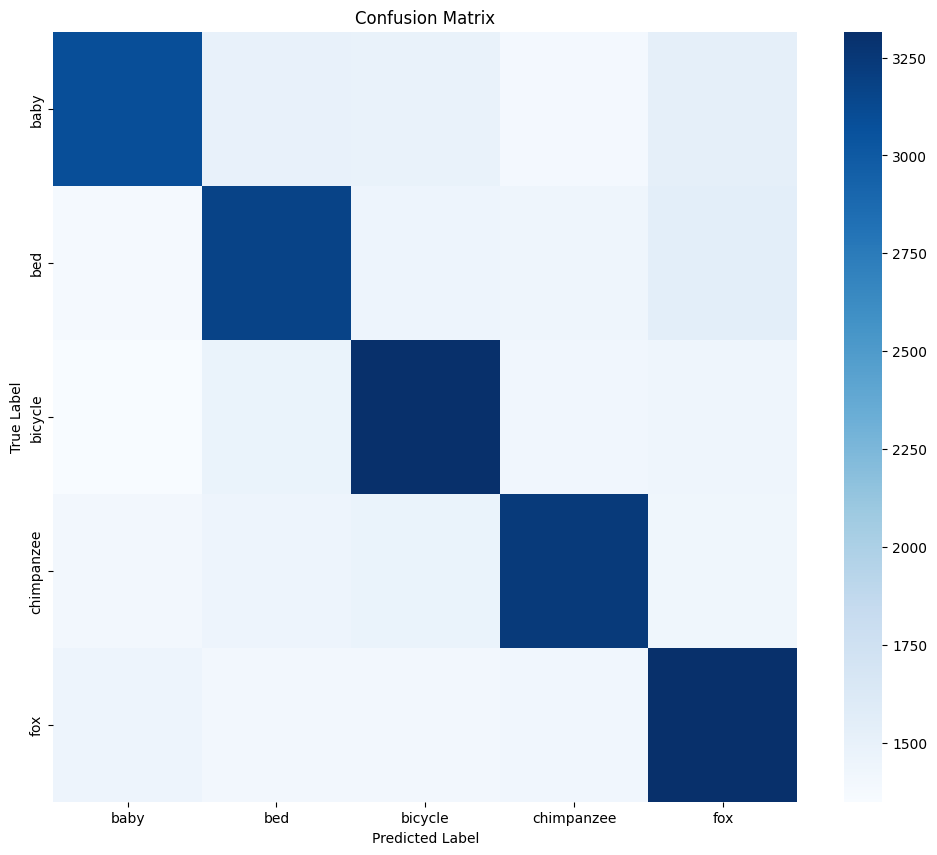

In [8]:
show_conf_matrix(all_targets, all_preds0)

In [ ]:
show_conf_matrix(all_targets, all_preds1)

In [11]:
fruits = ['apple', 'banana', 'cherry']

points = ('cherry', 1, 4, 5, 9)

fruits.extend(points)
fruits

['apple', 'banana', 'cherry', 'cherry', 1, 4, 5, 9]

In [13]:
val_loader, idx_to_class, semantic = load_data(args, device, sample=False)

In [15]:
semantic.keys()

dict_keys(['train', 'skyscraper', 'turtle', 'raccoon', 'spider', 'orange', 'castle', 'keyboard', 'clock', 'pear', 'girl', 'seal', 'elephant', 'apple', 'bus', 'mushroom', 'possum', 'squirrel', 'chair', 'tank', 'plate', 'wolf', 'road', 'mouse', 'boy', 'shrew', 'couch', 'sunflower', 'tiger', 'caterpillar', 'lion', 'streetcar', 'lawn_mower', 'tulip', 'forest', 'dolphin', 'cockroach', 'bear', 'porcupine', 'bee', 'hamster', 'lobster', 'bowl', 'can', 'bottle', 'trout', 'snake', 'bridge', 'pine_tree', 'skunk', 'lizard', 'cup', 'kangaroo', 'oak_tree', 'dinosaur', 'rabbit', 'orchid', 'willow_tree', 'ray', 'palm_tree', 'mountain', 'house', 'cloud', 'baby', 'bed', 'bicycle', 'chimpanzee', 'fox', 'leopard', 'man', 'pickup_truck', 'plain', 'poppy', 'rocket', 'rose', 'snail', 'sweet_pepper', 'table', 'telephone', 'wardrobe', 'whale', 'woman', 'worm', 'otter', 'motorcycle', 'television', 'lamp', 'crocodile', 'shark', 'butterfly', 'beaver', 'beetle', 'tractor', 'flatfish', 'maple_tree', 'camel', 'crab'

In [16]:
all_preds0, all_preds1, all_targets = [], [], []
    
for data, labels in tqdm(val_loader, desc="Testing"):
    all_targets.extend(labels.cpu().numpy())

Testing: 100%|████████████████████████████████████| 94/94 [00:57<00:00,  1.63it/s]


In [17]:
set(all_targets)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

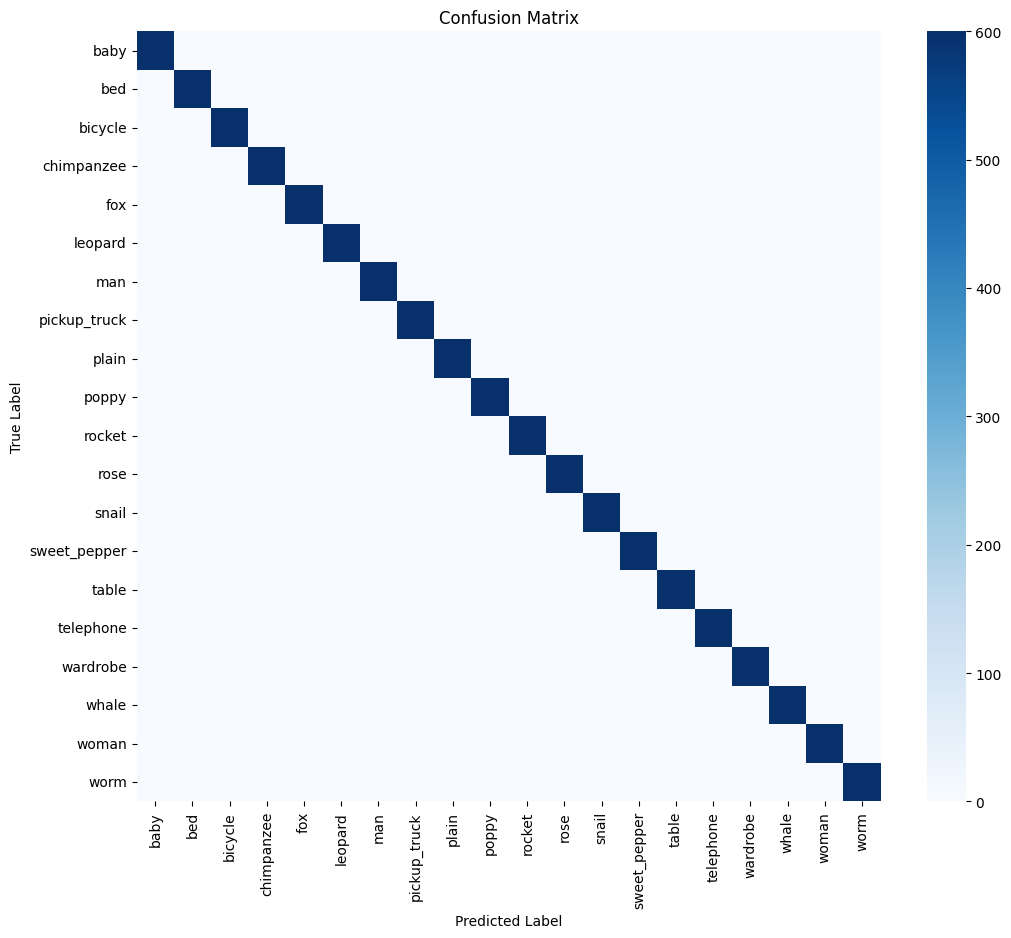

In [18]:
show_conf_matrix(all_targets, all_targets)